In [5]:
!nvidia-smi

Tue May  4 16:49:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!apt-get install libsm6 libxext6 libxrender-dev
!pip install torch==1.4.0
!pip install torchvision==0.5.0
!pip install albumentations==0.5.2
!pip install segmentation_models_pytorch
!pip install wandb
!pip install madgrad

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#[TODO]-코드-구현-Unet-" data-toc-modified-id="[TODO]-코드-구현-Unet--5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><font color="red">[TODO] 코드 구현 Unet </font></a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [8]:
import os, sys, time
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd

import segmentation_models_pytorch as smp

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

#개인 라이브러리
#sys.path.insert(0, '/content/drive/MyDrive/Colab\ Notebooks/pstage3')
#from utils import label_accuracy_score
#from loss import *

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

#wandb
import wandb

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P100-PCIE-16GB
1


In [9]:

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

## 하이퍼파라미터 세팅 및 seed 고정

In [10]:
#model setting
model_name = "efficientnet-b0"
pretrained_name = "imagenet"
augmentation_type = ""
optimizer_name = "adam"
scheduler_name = "schd_none"
criterion_name = "CrossEntropy"
group_name = 'DeepLab3_baser'

In [11]:
batch_size = 3   # Mini-batch size 
test_batch_size = 5
num_epochs = 10 #20 -> 10
learning_rate = 0.0001
#steplr
steplr_step_size=30; steplr_gamma=0.1

config = {"batch_size" : batch_size, "num_epochs" : num_epochs, "learning_rate" : learning_rate}
steplr_config = {"batch_size" : batch_size, "num_epochs" : num_epochs, "learning_rate" : learning_rate, "steplr_step_size" : steplr_step_size, "steplr_gamma":steplr_gamma}


In [12]:
# seed 고정
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [13]:
%matplotlib inline

dataset_path = '/content/drive/MyDrive/pstage_data/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


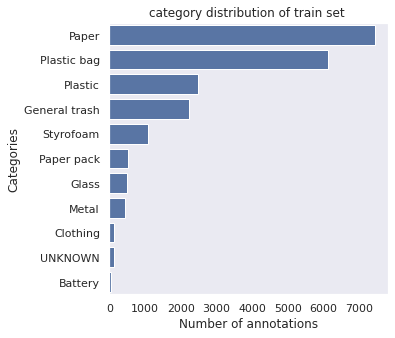

In [14]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [15]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [16]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


## 데이터 전처리 함수 정의 (Dataset)

In [17]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [18]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                             #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                             A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.2),
                             #A.RandomCrop(width=256, height=256),
                             #A.HorizontalFlip(p=0.5),
                             #A.RandomBrightnessContrast(p=0.2),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                            #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            #A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.2),
                            #A.RandomCrop(width=256, height=256),
                            #A.HorizontalFlip(p=0.5),
                            #A.RandomBrightnessContrast(p=0.2),
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

#test_batch_size 인지 염두
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=test_batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.82s)
creating index...
index created!
loading annotations into memory...
Done (t=2.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Paper', 3}]


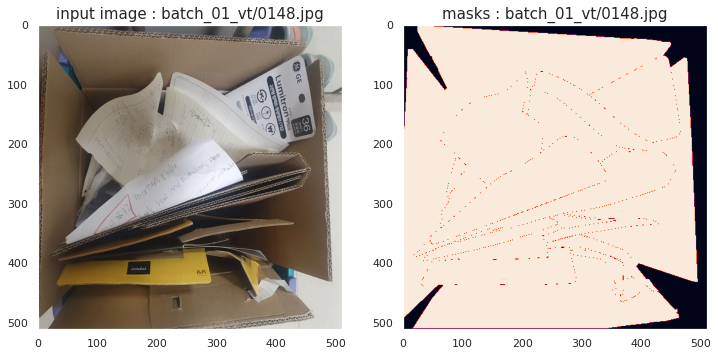

In [19]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 6}, {'Plastic', 7}, {9, 'Plastic bag'}]


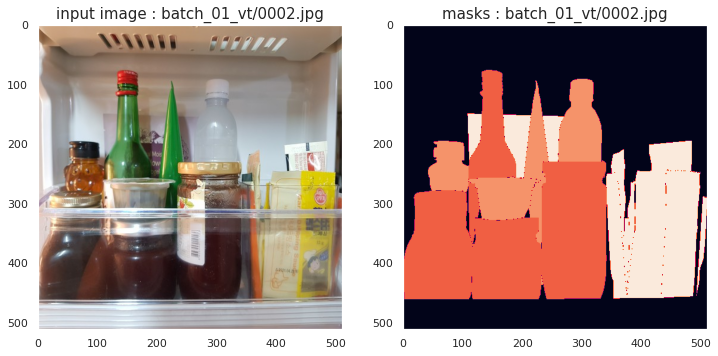

In [20]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


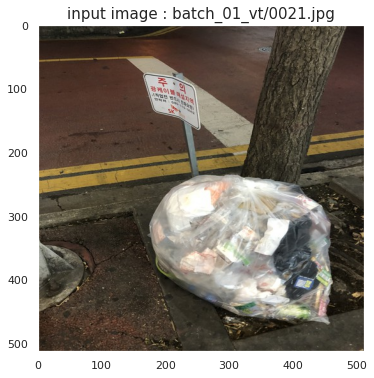

In [21]:
# test_loader의 output 결과(image 및 mask) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    # temp_masks = masks
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### <font color='red'>[TODO] 코드 구현 Unet </font>

In [22]:
"""
import torch
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self, num_classes=12):
        super(UNet, self).__init__()
        '''
        [TODO]

        ''' 

    def forward(self, x):
        '''
        [TODO]

        '''
        return x
"""

"\nimport torch\nimport torch.nn as nn\nclass UNet(nn.Module):\n    def __init__(self, num_classes=12):\n        super(UNet, self).__init__()\n        '''\n        [TODO]\n\n        ''' \n\n    def forward(self, x):\n        '''\n        [TODO]\n\n        '''\n        return x\n"

In [23]:
"""
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test

model = UNet(num_classes=12)
x = torch.randn([1, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)
"""

'\n# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test\n\nmodel = UNet(num_classes=12)\nx = torch.randn([1, 3, 512, 512])\nprint("input shape : ", x.shape)\nout = model(x).to(device)\nprint("output shape : ", out.size())\n\nmodel = model.to(device)\n'

## segmentation models 이용
### 주소 : https://github.com/qubvel/segmentation_models.pytorch

In [24]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3(
    encoder_name=model_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=pretrained_name,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth


## Wandb setting

In [25]:
#config 주의
wandb.init(group=group_name, project='gjtak', config=steplr_config)
wandb.run.name = ('D3_'+ model_name + "_" + pretrained_name + '_' + criterion_name + '_' + optimizer_name + '_' + scheduler_name +'_'+ augmentation_type)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## train, validation, test 함수 정의

In [26]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device, scheduler=None):
    print('Start training..')
    best_loss = 9999999
    #step_cnt = 0
    for epoch in range(num_epochs):
        model.train()
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
                  
            # inference
            outputs = model(images)
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
                #wandb
                wandb.log({"Train loss": float(loss.item())})
        #scheduler
        if scheduler != None :
            scheduler.step()
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [27]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            images, masks = images.to(device), masks.to(device)            

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()

            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list)))
        #wandb
        #wandb.log({"avrg_loss" : avrg_loss, "mIoU":np.mean(mIoU_list)}, step = epoch*len(val_loader)+step+1)
        wandb.log({"avrg_loss" : avrg_loss, "mIoU":np.mean(mIoU_list)})
    return avrg_loss

## 모델 저장 함수 정의

In [28]:
# 모델 저장 함수 정의
val_every = 1
#saved_file_name='D3_best_model'
saved_file_name = ('D3_'+ model_name + "_" + pretrained_name + '_' + criterion_name + '_' + optimizer_name + '_' + scheduler_name +'_'+ augmentation_type)
saved_dir = '/content/drive/MyDrive/pstage_data/saved'
if not os.path.isdir(saved_dir):                                                    
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name=saved_file_name+'.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의
### focal loss : https://pypi.org/project/focal-loss-torch/ (https://github.com/mathiaszinnen/focal_loss_torch)

In [29]:
# -- Focal Loss
# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [30]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
#focal loss
#criterion = FocalLoss(alpha=1, gamma=2)#2,5

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=steplr_step_size, gamma=steplr_gamma)
scheduler = None

## wandb watch

In [31]:
wandb.watch(model, criterion, log="all")

In [32]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device, scheduler)
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()
print("<<<total train_time>>>")
print(start.elapsed_time(end))

Start training..
Epoch [1/10], Step [25/873], Loss: 1.6571
Epoch [1/10], Step [50/873], Loss: 1.4946
Epoch [1/10], Step [75/873], Loss: 0.9567
Epoch [1/10], Step [100/873], Loss: 0.9688
Epoch [1/10], Step [125/873], Loss: 1.9845
Epoch [1/10], Step [150/873], Loss: 0.7290
Epoch [1/10], Step [175/873], Loss: 0.6792


KeyboardInterrupt: ignored

## 저장된 model 불러오기 (학습된 이후) 

In [ ]:
# best model 저장된 경로
#model_path = '/content/drive/MyDrive/pstage_data/saved/D3_best_model.pt'
model_path = '/content/drive/MyDrive/pstage_data/saved/'+saved_file_name+'.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

In [ ]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 2
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

plt.show()

## submission을 위한 test 함수 정의

In [ ]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
            if (step + 1) % 25 == 0:
                print('Step [{}/{}]'.format(step+1, len(train_loader)))
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv('/content/drive/MyDrive/pstage_data/submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
# file name ex = "Baseline_D3_resnet50_imagenet.csv"

steplr_config_str = '_(step'+str(steplr_step_size)+'_gamma_'+str(steplr_gamma)+')'
file_scheduler_name = scheduler_name + steplr_config_str
final_file_name = 'Baseline_D3_'+ model_name + "_" + pretrained_name + '_' + criterion_name + '_' + \
                    optimizer_name + '_' + file_scheduler_name + "_"+augmentation_type
submission.to_csv("/content/drive/MyDrive/pstage_data/submission/"+ final_file_name+ ".csv", index=False)

## Reference

